In [1]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Loading dataset from Hugging Face and converting it to a pandas DataFrame
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

# Converting the 'job_posted_date' column to datetime format
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Converting 'job_skills' string representations of lists into actual Python lists
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
# Define the country of interest
v_job_country = 'India'

# Define the specific job title for focused analysis
v_job_title = 'Data Scientist'

# Number of top skills to consider in analysis or visualization
v_skills = 5

# List of job titles for broader comparative analysis
my_job_titles = ['Data Scientist', 'Data Engineer', 'Data Analyst']

In [3]:
# Filter dataset for jobs posted in the specified country
df_Ind = df[df['job_country'] == v_job_country].copy()

# Explode the 'job_skills' list so each skill is a separate row for country-level analysis
df_Ind_explode = df_Ind.explode('job_skills')

In [4]:
# Group by job title and skill to count occurrences of each skill per job title
skill_count = df_Ind_explode.groupby(['job_title_short', 'job_skills']).size()

# Reset index to convert Series to DataFrame with a named column
df_skill_count = skill_count.reset_index(name='skill_count')

# Sort the DataFrame by skill count in descending order to prioritize most common skills
df_skill_count.sort_values(by='skill_count', ascending=False, inplace=True)

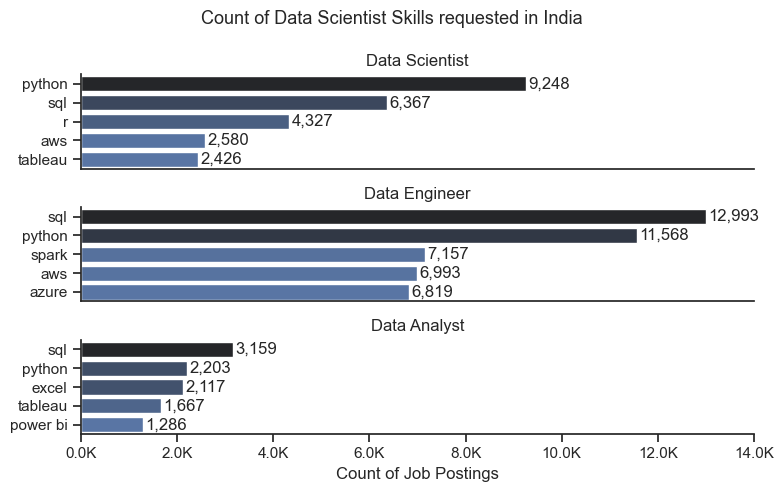

In [5]:
# Set Seaborn theme for consistent styling
sns.set_theme(style='ticks')

# Create a figure with subplots, one row per job title
fig, ax = plt.subplots(len(my_job_titles), 1, figsize=(8, 5))

# Loop through each job title to plot their top skills
for i, job_title in enumerate(my_job_titles):
    # Filter top skills for the current job title
    df_plot = df_skill_count[df_skill_count['job_title_short'] == job_title].head(v_skills)

    # Plot horizontal bar chart for skill counts
    sns.barplot(data=df_plot,
                x='skill_count',
                y='job_skills',
                hue='skill_count',
                palette='dark:b_r',
                ax=ax[i])
    
    # Set x-axis limit to keep bars comparable across subplots
    ax[i].set_xlim(0, 14_000)

    # Format x-axis ticks for the last subplot only, else remove ticks for neatness
    if i == len(my_job_titles) - 1:
        ax[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{float(x/1000)}K"))
    else:
        ax[i].set_xticks([])

    # Add skill count text labels at the end of bars
    for j, count in enumerate(df_plot['skill_count']):
        ax[i].text(count + 50, j, f"{count:,}", va='center')

    # Set the subplot title as the job title
    ax[i].set_title(job_title)

    # Set x-axis label only for the bottom plot
    if i == len(my_job_titles) - 1:
        ax[i].set_xlabel('Count of Job Postings')
    else:
        ax[i].set_xlabel('')

    # Remove y-axis labels for a cleaner look
    ax[i].set_ylabel('')

    # Remove legend since hue duplicates the count info
    ax[i].legend().remove()

    # Remove top and right spines for visual clarity
    sns.despine()

# Set overall figure title with dynamic job title and country
fig.suptitle(f"Count of {v_job_title} Skills requested in {v_job_country}", fontsize=13)

# Adjust layout to prevent overlapping elements
fig.tight_layout()

# Display the plot
plt.show()

In [6]:
# Count total job postings per job title within the country
Ind_job_count = df_Ind['job_title_short'].value_counts().to_frame(name='job_count')

# Merge skill counts with total job counts per job title to calculate skill percentages
df_skill_count_perc = df_skill_count.merge(Ind_job_count, on='job_title_short')

# Calculate the percentage of job postings requesting each skill for a given job title
df_skill_count_perc['skill_perc'] = 100 * (df_skill_count_perc['skill_count'] / df_skill_count_perc['job_count'])

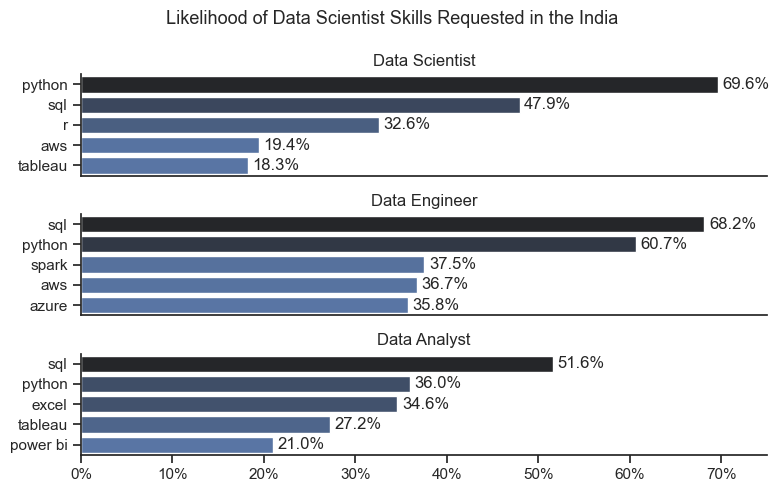

In [8]:
from matplotlib.ticker import PercentFormatter

# Set Seaborn theme for consistent plot styling
sns.set_theme(style='ticks')

# Create subplots: one row per job title
fig, ax = plt.subplots(len(my_job_titles), 1, figsize=(8, 5))

# Loop through each job title to plot skill percentage bars
for i, job_title in enumerate(my_job_titles):
    # Filter top skills for the current job title
    df_plot = df_skill_count_perc[df_skill_count_perc['job_title_short'] == job_title].head(v_skills)

    # Plot horizontal bar chart of skill percentage for each skill
    sns.barplot(data=df_plot,
                x='skill_perc',
                y='job_skills',
                hue='skill_perc',
                palette='dark:b_r',
                ax=ax[i])

    # Set x-axis limits for percentage scale
    ax[i].set_xlim(0, 75)

    # Remove legend to avoid redundancy since hue duplicates x-axis info
    ax[i].legend().remove()

    # Format x-axis as percentages only on the bottom subplot; hide ticks on others
    if i == len(my_job_titles) - 1:
        ax[i].xaxis.set_major_formatter(PercentFormatter())
    else:
        ax[i].set_xticks([])

    # Add text labels with precise percentage values to each bar
    for j, perc in enumerate(df_plot['skill_perc']):
        ax[i].text(perc + 0.5, j, f"{perc:.1f}%", va='center')

    # Set subplot title to current job title
    ax[i].set_title(job_title)

    # Remove axis labels for a cleaner look
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

    # Remove top and right spines for visual clarity
    sns.despine()

# Set an overall title for the figure with dynamic job title and country
fig.suptitle(f"Likelihood of {v_job_title} Skills Requested in the {v_job_country}", fontsize=13)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the figure
plt.show()